In [1]:
import os, sys, shutil
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append("../src")
from utils import *
from autoencoder import AutoEncoder
from gnet8_encoder import GNet8_Encoder
from reconstructor import Reconstructor
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import matplotlib.image as mpimg
import random
from transformers import AutoProcessor, AutoTokenizer, CLIPVisionModelWithProjection, CLIPTextModelWithProjection
os.chdir("..")

/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
R = Reconstructor(which='v1.0', fp16=True, device="cuda:1")


#######################
# Running in eps mode #
#######################

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Load pth from pretrained/kl-f8.pth
Load autoencoderkl with total 83653863 parameters,72921.759 parameter sum.
Load optimus_bert_connector with total 109489920 parameters,19422.035 parameter sum.
Load optimus_gpt2_connector with total 132109824 parameters,19080.306 parameter sum.
Load pth from pretrained/optimus-vae.pth
Load optimus_vae_next with total 241599744 parameters,-344611.688 parameter sum.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Load clip_image_context_encoder with total 427616513 parameters,64007.510 parameter sum.
Load clip_text_context_encoder with total 427616513 parameters,64007.510 parameter sum.
Load openai_unet_2d_next with total 859520964 parameters,99762.122 parameter sum.
Load openai_unet_0d_next with total 1706797888 parameters,249908.364 parameter sum.
Load vd_v2_0 with total 3746805485 parameters,205995.576 parameter sum.
cuda:1


In [3]:
device = "cuda:1"
_, _, x_test, _, _, images, _ = load_nsd(vector="images", subject=1, loader=False, average=False, nest=True, return_sessions=False, include_heldout=True)
model_id = "openai/clip-vit-large-patch14"
processor = AutoProcessor.from_pretrained(model_id)
visionmodel = CLIPVisionModelWithProjection.from_pretrained(model_id).to(device)

torch.Size([30000, 15724])


loading samples: 100%|██████████| 30000/30000 [00:12<00:00, 2368.96it/s] 


Data Shapes... x_train: torch.Size([22950, 15724]), x_val: torch.Size([4050, 15724]), x_test: torch.Size([1000, 3, 15724]), y_train: torch.Size([22950, 541875]), y_val: torch.Size([4050, 541875]), y_test: torch.Size([1000, 541875])


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.k_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.q_proj.weight', 'text_model.encoder.layers.2.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.10.mlp.fc2.weight', 'text_model.encoder.layers.8.mlp.fc1.bias', 'text_model.encoder.layers.3.mlp.fc2.weight', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.2.layer_norm1.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.6.self_attn.q_proj.bias', '

In [4]:
def calculate_clip_cosine_sim(image1, image2):
        with torch.no_grad():
            inputs = processor(images=[image1, image2], return_tensors="pt", padding=True).to(device)
            outputs = visionmodel(**inputs)
            
            gt_feature = outputs.image_embeds[0].reshape((768))
            reconstruct_feature = outputs.image_embeds[1].reshape((768))
            clip_cosine_sim = torch.nn.functional.cosine_similarity(gt_feature, reconstruct_feature, dim=0)
        return float(clip_cosine_sim)

In [5]:
image_list = [Image.fromarray(images[i].numpy().reshape((425, 425, 3)).astype(np.uint8)) for i in range(1000)]
clip_embeddings = torch.zeros((1000, 768))
for i, image in tqdm(enumerate(image_list)):
    with torch.no_grad():
        inputs = processor(images=[image], return_tensors="pt", padding=True).to(device)
        outputs = visionmodel(**inputs)
        clip_embeddings[i] = outputs.image_embeds[0].reshape((768)).cpu()

1000it [00:33, 30.19it/s]


In [6]:

dissimilarity_matrix = np.zeros((1000, 1000), dtype=np.float32)

for i in tqdm(range(1000)):
    for j in range(1000):
        embed1 = clip_embeddings[i]
        embed2 = clip_embeddings[j]
        cosine_similarity = torch.nn.functional.cosine_similarity(embed1, embed2, dim=0)
        dissimilarity_matrix[i, j] = 1 - cosine_similarity


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:42<00:00, 23.65it/s]


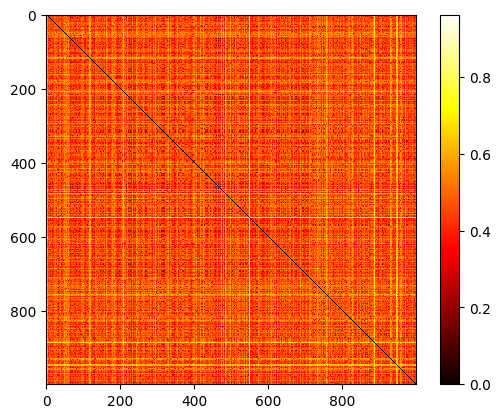

In [7]:
import matplotlib.pyplot as plt

plt.imshow(dissimilarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


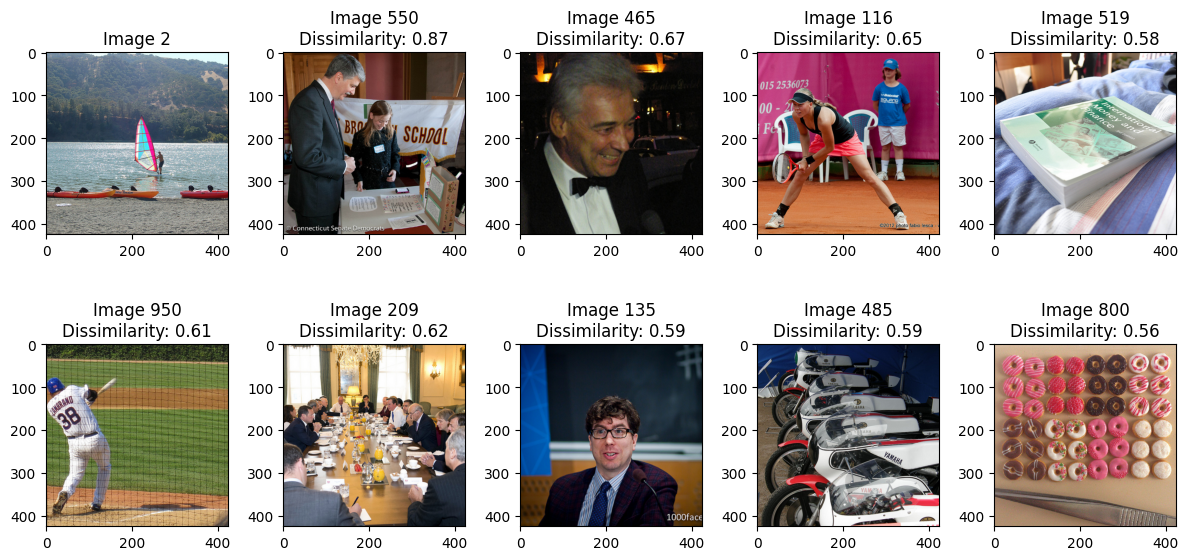

In [8]:
# Find the indices of the 10 most dissimilar images to image 2
most_dissimilar_indices = np.argsort(dissimilarity_matrix[3])[::-1][:9]

# Get the dissimilarity scores for the 10 most dissimilar images
dissimilarity_scores = dissimilarity_matrix[2][most_dissimilar_indices]

# Display image 2 and the 10 most dissimilar images with their dissimilarity scores
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

# Display image 2
axes[0].imshow(image_list[3])
axes[0].set_title("Image 2")

# Display the 10 most dissimilar images with their dissimilarity scores
for i, index in enumerate(most_dissimilar_indices):
    axes[i+1].imshow(image_list[index])
    axes[i+1].set_title(f"Image {index}\nDissimilarity: {dissimilarity_scores[i]:.2f}")

plt.tight_layout()
plt.show()


[0.0, 5.748243393252646, 41.44485613894877, 131.62267862404812, 298.8175661445351, 564.416447853799, 949.0000000000001]
10 7


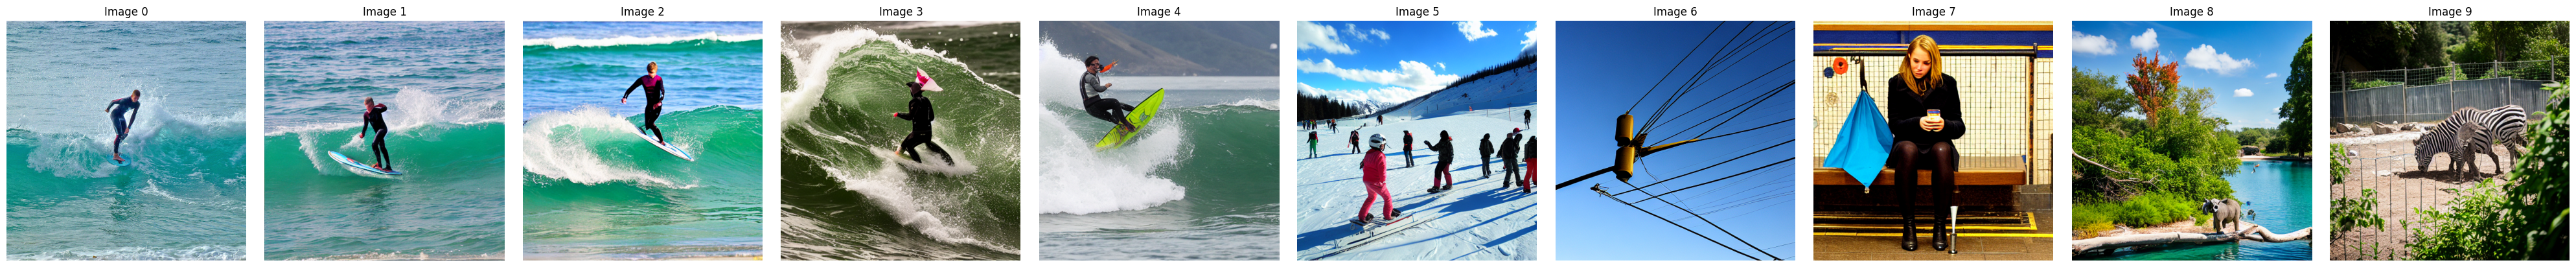

In [21]:
import numpy as np
import matplotlib.pyplot as plt

image_0 = image_list[2]
base_embeds = R.encode_image(image_0)
calibration_scale_images = [image_0]
for strength in [0.75, 1.0]:
    calibration_scale_images.append(R.reconstruct(image=image_0,
                        c_i=base_embeds,
                        strength=strength))

sorted_indices = np.argsort(dissimilarity_matrix[2])
filtered_indices = sorted_indices[25:-25]
# Define the maximum x value and the desired number of steps
max_x = 5
num_steps = len(filtered_indices)

# Generate the x values
x_values = [0, 1, 2, 3, 4, 5, 6]

# Fit an x^n curve
n = 2.85  # Change this value to adjust the curve

# Calculate the coefficient to make the value at x=4 equal to num_steps
coefficient = (num_steps-1) / (6 ** n)

# Calculate the y values with the modified coefficient
y_values = [coefficient * (x ** n) for x in x_values]

# Select the y values at the remaining x values as the steps
steps = [y_values[int(step)] for step in x_values]
print(steps)
selected_indices = [filtered_indices[int(step)] for step in steps]
# Display the selected images in a horizontal grid
fig, axes = plt.subplots(1, 10, figsize=(40, 4))

for i, index in enumerate(selected_indices):
    calibration_scale_images.append(R.reconstruct(c_i=R.encode_image(image_list[index]),strength=1))
print(len(calibration_scale_images), len(selected_indices))
for i, img in enumerate(calibration_scale_images):
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i}") # \nDissimilarity: {dissimilarity_matrix[2][index]:.2f}

# Remove axis labels
for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()
